<a href="https://colab.research.google.com/github/NID123-CH/DSR-40/blob/main/DSR_40_Timeseries_STL_Decomposition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Seasonal Trend Loess (STL) Decomposition

> _STL is a versatile and robust method for decomposing time series. STL is an acronym for “Seasonal and Trend decomposition using Loess”, while Loess is a method for estimating nonlinear relationships. The STL method was developed by R. B. Cleveland, Cleveland, McRae, & Terpenning (1990).
>
> STL has several advantages over the classical, SEATS and X11 decomposition methods:
>
> - Unlike SEATS and X11, STL will handle any type of seasonality, not only monthly and quarterly data.
> - The seasonal component is allowed to change over time, and the rate of change can be controlled by the user.
> - The smoothness of the trend-cycle can also be controlled by the user.
>
> It can be robust to outliers (i.e., the user can specify a robust decomposition), so that occasional unusual observations will not affect the estimates of the trend-cycle and seasonal components. They will, however, affect the remainder component.
>
> On the other hand, STL has some disadvantages. In particular, it does not handle trading day or calendar variation automatically, and it only provides facilities for additive decompositions._
>
> Source: [STL decomposition, Forecasting: Principles and Practice](https://otexts.com/fpp2/stl.html)

In this chapter, we'll go over a slightly simplified version of STL decomposition.

Let's start by loading the good old passenger data. We've been using the log transformation from the start, which is very convenient, since STL can only handle additive decomposition.

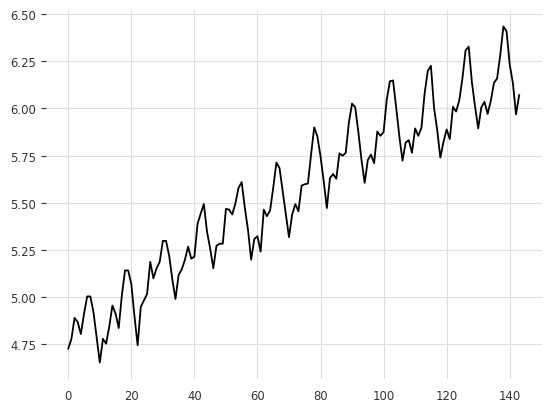

In [11]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
df = pd.read_csv('https://datasets-nixtla.s3.amazonaws.com/air-passengers.csv', parse_dates=['ds'])
df['ds'] = df['ds'] + pd.offsets.MonthEnd() # otherwise CV breaks some join inside the function
df['log_y'] = np.log(df.y+1)
y = df.log_y
plt.plot(y)

Just like we did in the previous chapter, let's fit the model using statsmodels' `STL` class. This time, we're making some default arguments explicit, namely, `seasonal_deg`, `trend_deg` and `low_pass_deg`, which control the degree used to fit the LOESS to their corresponding components.

In [12]:
from statsmodels.tsa.seasonal import STL

freq = 12
s_window = 7

stl = STL(y, period=freq, seasonal=s_window, seasonal_deg=1, trend_deg=1, low_pass_deg=1)
res = stl.fit()
df1 = pd.concat([res.trend, res.seasonal, res.resid], axis=1)
df1.tail(5)

,trend,season,resid
139,6.166996,0.262223,-0.020690
140,6.174482,0.057647,0.000318
141,6.181907,-0.054841,0.008499
142,6.189277,-0.213827,-0.006742
143,6.196599,-0.122670,-0.003191


## DARTS

In [13]:
!pip install darts

In [14]:
from darts import TimeSeries
from darts.utils.statistics import extract_trend_and_seasonality
from darts.utils.utils import ModelMode, SeasonalityMode

y_ts = TimeSeries.from_series(y)
trend_d, seasonal_d = extract_trend_and_seasonality(y_ts, freq=freq, model=ModelMode.ADDITIVE, method='STL')
trend_d[-5:], seasonal_d[-5:]

(<TimeSeries (DataArray) (time: 5, component: 1, sample: 1)> Size: 40B
 array([[[6.1669957 ]],
 
        [[6.17448239]],
 
        [[6.18190677]],
 
        [[6.1892774 ]],
 
        [[6.19659889]]])
 Coordinates:
   * time       (time) int64 40B 139 140 141 142 143
   * component  (component) <U1 4B '0'
 Dimensions without coordinates: sample
 Attributes:
     static_covariates:  None
     hierarchy:          None,
 <TimeSeries (DataArray) (time: 5, component: 1, sample: 1)> Size: 40B
 array([[[ 0.26222275]],
 
        [[ 0.05764713]],
 
        [[-0.05484068]],
 
        [[-0.21382734]],
 
        [[-0.12267009]]])
 Coordinates:
   * time       (time) int64 40B 139 140 141 142 143
   * component  (component) <U1 4B '0'
 Dimensions without coordinates: sample
 Attributes:
     static_covariates:  None
     hierarchy:          None)

## SkTime

In [23]:
!pip install sktime --upgrade

In [24]:
from sktime.transformations.series.detrend import STLTransformer
transformer = STLTransformer(sp=12)
y_hat = transformer.fit_transform(y)

In [25]:
transformer.trend_[-5:], transformer.seasonal_[-5:]

(time
 139    6.166996
 140    6.174482
 141    6.181907
 142    6.189277
 143    6.196599
 dtype: float64,
 time
 139    0.262223
 140    0.057647
 141   -0.054841
 142   -0.213827
 143   -0.122670
 dtype: float64)

## Step-by-Step

The basic STL decomposition follow this sequence of steps:
- applies LOESS to find a smooth trend (Tt) using `t_window` points/neighbors
- detrends the series (y-Tt)
- builds `period` (12, in our case, one for each month) sub-series
- applies LOESS to find smooth seasonal trends for each sub-series using `s_window` points/neighbors
  - the full algorithm includes a low-pass filter and detrending of each of these subseries before moving on to the next step - we're skipping those for the sake of simplicity (you can check more details [here](http://www.gardner.fyi/blog/STL-Part-II/)
- uses the smoothed seasonal trends to build a smooth seasonal component (St)
- deseasonalizes the original series (y-St)
- applies yet another LOESS to the deseasonalized series to get a final smooth trend (Tt)
- computes the remainder (Rt) by subtracting St and Tt from the original series (y)

If you recall from before, the only required arguments are `period` and `s_window`:

In [26]:
period = 12
s_window = 7

Internally, STL uses the formula below to find the `t_window` it will use to fit LOESS to the data in order to estimate its trend:

In [27]:
import math

def nextodd(x):
    x = int(round(x))  # int() because Python 2's round returns a float
    if x % 2 == 0:
        x += 1
    return x

t_window = nextodd(int(math.ceil(1.5 * period / (1 - 1.5 / s_window))))
t_window

23

Next, we fit LOESS to the original data (we're using `it=0` to get the basic LOESS without any further refinements):

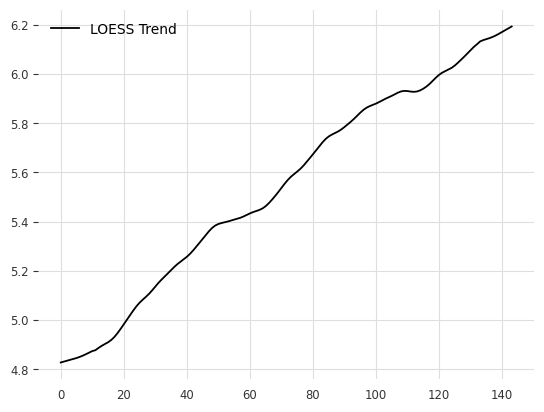

In [28]:
import statsmodels.api as sm
lowess = sm.nonparametric.lowess

y = df.log_y
lowess_trend = lowess(y, np.arange(len(y)), frac=min(1, t_window/len(y)), it=0)[:, 1].squeeze()
plt.plot(lowess_trend, label='LOESS Trend')
plt.legend()

Once the trend is computed, we can use it to detrend the series:

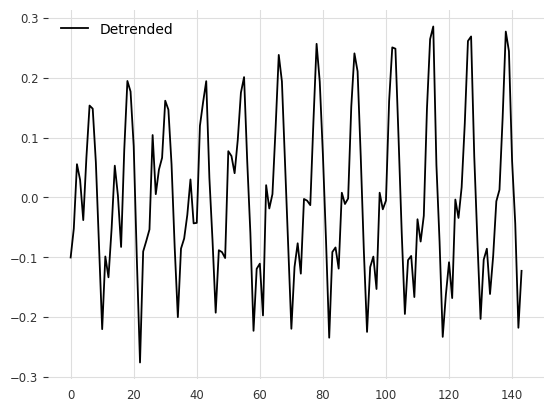

In [29]:
detrended = y - lowess_trend
plt.plot(detrended, label='Detrended')
plt.legend()

Of course, seasonality is still there. In traditional decomposition, we would compute the average value for all Januaries, then for all Februaries, and so and so forth, resulting in the "average season".

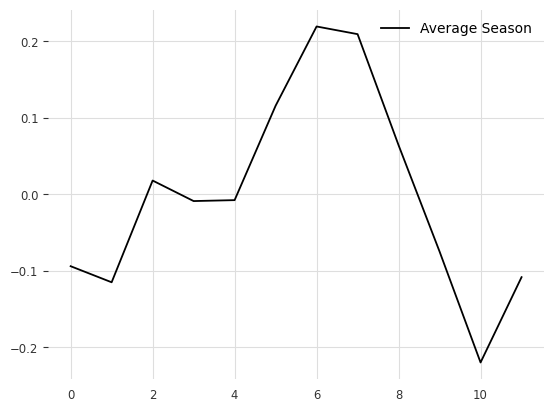

In [30]:
mean_season = np.array([np.nanmean(detrended[i::period]) for i in range(period)])
plt.plot(mean_season, label='Average Season')
plt.legend()

The average season would then be replicated over the entire length of the series.

STL's decomposition, however, is able to take into account inner trends in seasonality, as it can be seen in the plot below comparing both approaches:

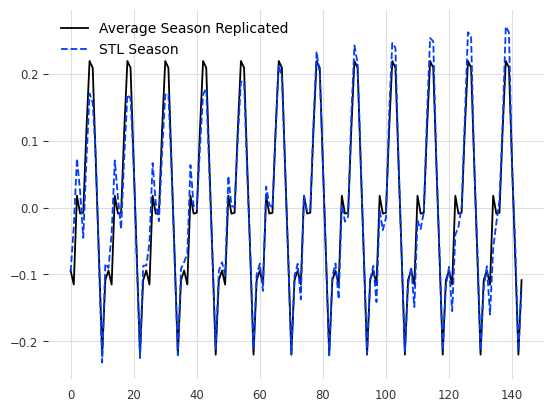

In [31]:
seasonal_comp = np.tile(mean_season, np.ceil(len(y)/period).astype(int))[:len(y)]
plt.plot(seasonal_comp, label='Average Season Replicated')
df1['season'].plot(label='STL Season', linestyle='--')
plt.legend()

So, let's go the STL way and build 12 sub-series, one for each time unit in the seasonal period. In our case, one sub-series for each month. For each sub-series, a LOESS is computed using `s_window` to determine how many points/neighbors are being used to smoothen the sub-series.

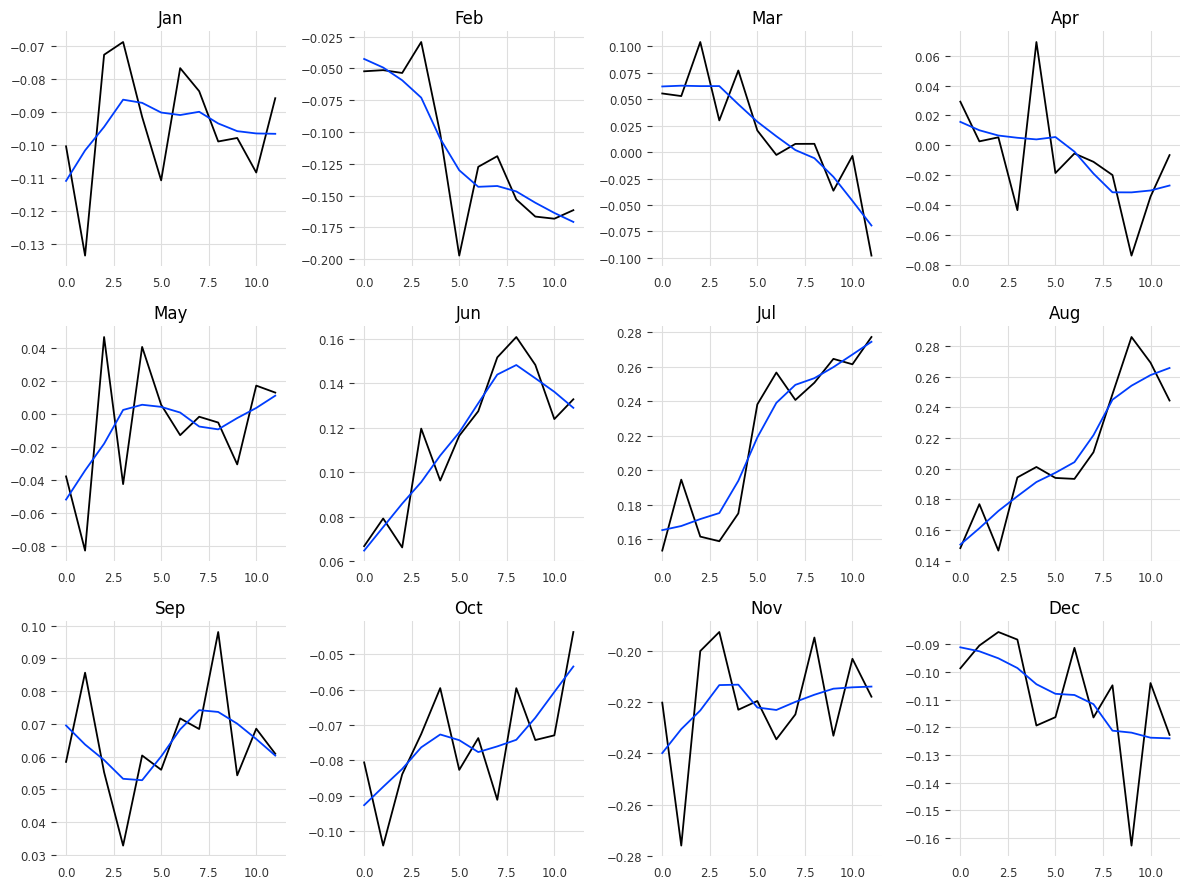

In [32]:
seasons = [detrended[i::period] for i in range(period)]
fig, axs = plt.subplots(3, 4, figsize=(12, 9))
axs = axs.flatten()
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
season_unit = []
for i in range(period):
    season_unit.append(lowess(seasons[i], np.arange(period), frac=min(1, s_window/len(seasons[i])), it=0)[:, 1].squeeze())
    axs[i].plot(seasons[i].values)
    axs[i].plot(season_unit[i])
    axs[i].set_title(months[i])
fig.tight_layout()

The fitted values for each monthly LOESS are then used to rebuild the full seasonal component:

In [33]:
lowess_season = np.zeros_like(y)
for i in range(period):
    lowess_season[i::period] = season_unit[i]

Now we can compare our own values with statsmodels's `STL` results, and they match. Moreover, the months of January and July are being connected across the whole period to illustrate the smoothed trends computed for each month:

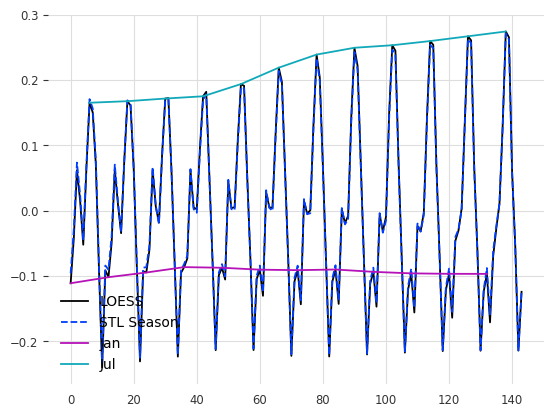

In [34]:
plt.plot(lowess_season, label='LOESS')
df1['season'].plot(label='STL Season', linestyle='--')
plt.plot(range(len(y))[0::period], lowess_season[0::period], label='Jan')
plt.plot(range(len(y))[6::period], lowess_season[6::period], label='Jul')
plt.legend()

Once we have the seasonal component, we can deseasonalize the original series:

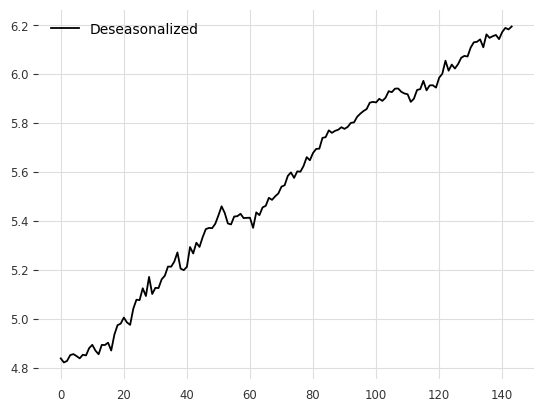

In [35]:
deaseasonalized = y - lowess_season
plt.plot(deaseasonalized, label='Deseasonalized')
plt.legend()

And then we can run the LOESS algorithm to find a smooth trend once again. We can compare our own smoothed trend with statsmodels's `STL` results and they mostly match (except for some value in the beginning):

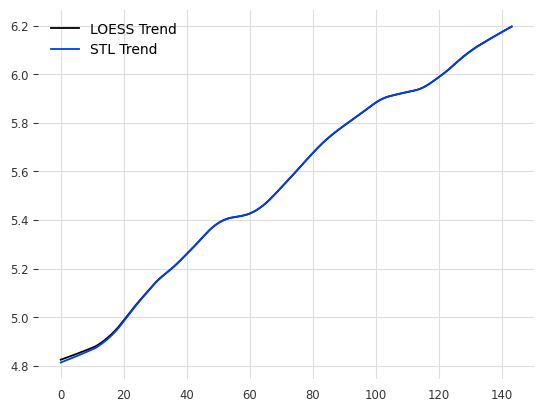

In [36]:
lowess_trend = lowess(deaseasonalized, np.arange(len(y)), frac=min(1, t_window/len(y)), it=0)[:, 1].squeeze()
plt.plot(lowess_trend, label='LOESS Trend')
df1['trend'].plot(label='STL Trend')
plt.legend()

What's left? Computing the remainder, of course. We can compare ours to STL's and, once again, they are a pretty close match.

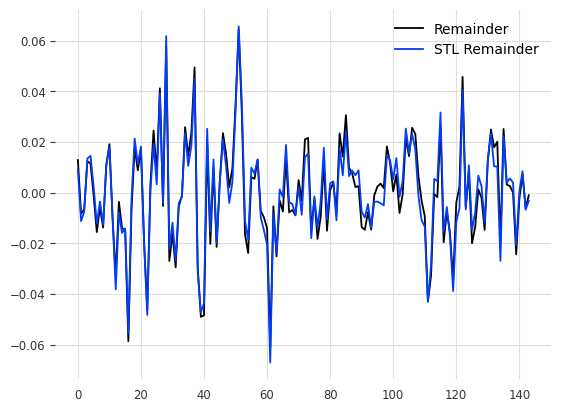

In [37]:
remainder = y - lowess_trend - lowess_season
plt.plot(remainder, label='Remainder')
df1['resid'].plot(label='STL Remainder')
plt.legend()

(-0.08, 0.08)

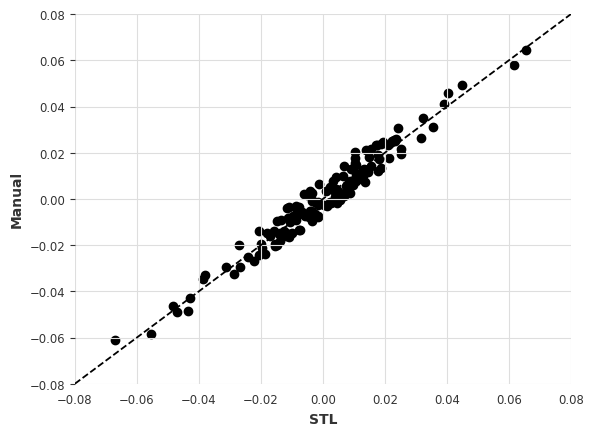

In [38]:
plt.scatter(df1['resid'].values, remainder)
plt.xlabel('STL')
plt.ylabel('Manual')
plt.plot([-.08, .08], [-.08, .08], linestyle='--')
plt.xlim([-.08, .08])
plt.ylim([-.08, .08])

## Forecast

Forecasting, in the context of the STL decomposition, is divided into two parts: the deseasonalized (trend and remainder) part, and the seasonal part. The idea is to run some forecasting algorithm of your choice to the deseasonalized part, and then add the last fitted season (from the STL decomposition) on top of the forecast.

Since the seasonality is already taken care of, we can use Double Exponential Smoothing to forecast values of a trending series. Let's create an instance of such model:

In [40]:
from statsmodels.tsa.statespace import exponential_smoothing

ES = exponential_smoothing.ExponentialSmoothing
config = {"trend": True}

These were the results from the STL decomposition:

In [41]:
df1

,trend,season,resid
0,4.813996,-0.095639,0.009031
1,4.819095,-0.028729,-0.011242
2,4.824225,0.073729,-0.007604
3,4.829397,0.024665,0.013472
4,4.834628,-0.045140,0.014533
...,...,...,...
139,6.166996,0.262223,-0.020690
140,6.174482,0.057647,0.000318
141,6.181907,-0.054841,0.008499
142,6.189277,-0.213827,-0.006742


We can rebuild the deseasonalized series by adding the remainder back to the trend.

In [42]:
deseasonalized = df1['trend'] + df1['resid']

Then, we fit the DES model to it:

In [43]:
trend_model = ES(deseasonalized, **config).fit()
trend_model.params

,0
smoothing_level,0.620847
smoothing_trend,0.000100
initial_level,4.804481
initial_trend,0.009651


Let's use the DES model to forecast 12 values ahead:

In [44]:
deseason_fcast = trend_model.forecast(12)
deseason_fcast

,predicted_mean
144,6.204626
145,6.214277
146,6.223928
147,6.233579
148,6.243231
149,6.252882
150,6.262533
151,6.272184
152,6.281836
153,6.291487


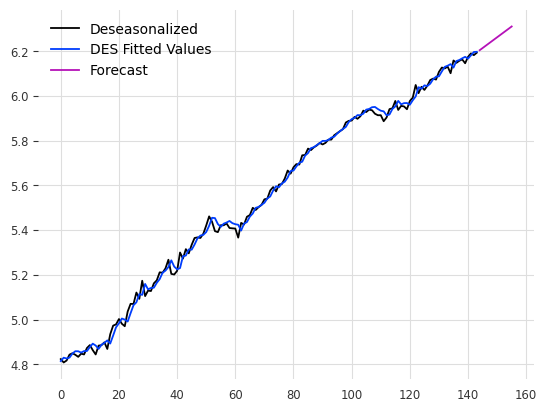

In [45]:
plt.plot(deseasonalized, label='Deseasonalized')
plt.plot(trend_model.predict(), label='DES Fitted Values')
plt.plot(deseason_fcast, label='Forecast')
plt.legend()

Looks good! So, let's get the last 12 seasonal values from the decomposition:

In [46]:
last_season = df1['season'].values[-12:]
last_season

array([-0.08763698, -0.15986557, -0.06138977, -0.02306405,  0.01106614,
        0.12669507,  0.27115712,  0.26222275,  0.05764713, -0.05484068,
       -0.21382734, -0.12267009])

Now, we simply add them to our forecast:

In [47]:
season_fcast = last_season + deseason_fcast
season_fcast

,predicted_mean
144,6.116989
145,6.054411
146,6.162538
147,6.210515
148,6.254297
149,6.379577
150,6.533690
151,6.534407
152,6.339483
153,6.236646


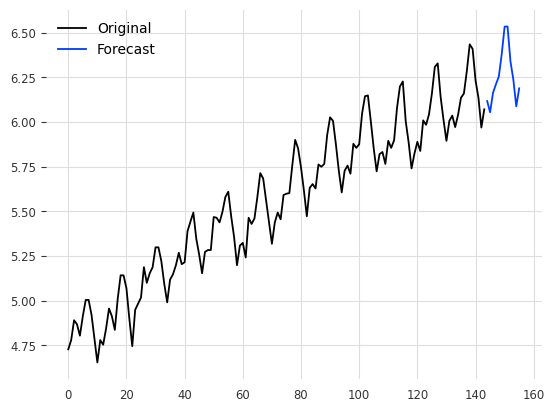

In [48]:
plt.plot(y, label='Original')
plt.plot(season_fcast, label='Forecast')
plt.legend()

Looks pretty good, don't you think?

Of course, we don't have to do all of this manually. We can simply define the model we'd like to use to forecast the deseasonalized series, and use statsmodels' `STLForecast` to do the heavy lifting for us:

In [49]:
from statsmodels.tsa.api import STLForecast

stlf = STLForecast(y, ES, model_kwargs=config, period=period, seasonal=s_window)
res = stlf.fit()
forecasts = res.forecast(freq)

In [50]:
forecasts

,0
144,6.116989
145,6.054411
146,6.162538
147,6.210515
148,6.254297
149,6.379577
150,6.533690
151,6.534407
152,6.339483
153,6.236646


Awesome, we have matching values!

These are the basics of the STL decomposition. However, the full implementation in statsmodels also has the ability to use robust weights, which is pretty useful to help us pinpoint outliers in the series.

## Outliers

Let's load some data with a clear outlier to illustrate how to use STL's remainders and Tukey's fences to identify outliers. The original example can be found [here](https://robjhyndman.com/hyndsight/tsoutliers/).

The gold data, a typical R dataset, contains daily morning gold prices from 1 January 1985 to 31 March 1989 and is available through statsmodels API as well. It contains 34 missing values and one value clearly out of the typical range - the outlier candidate.

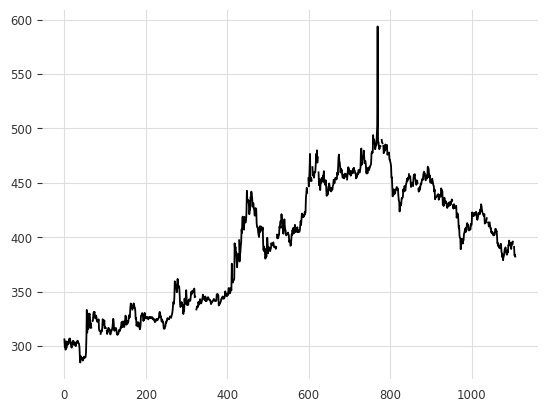

In [ ]:
import statsmodels.api as sm

gold = sm.datasets.get_rdataset("gold", "forecast")
y = gold.raw_data['value'].values
plt.plot(y)

Unfortunately, STL decomposition, as implemented in statsmodels, does not handle missing values. In a previous chapter, we used ARMA models to fill missing values. This time, for the sake of simplicity, we're using SkTime's `Imputer` instead.

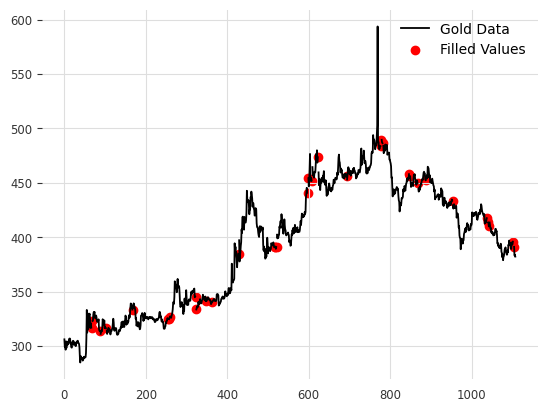

In [ ]:
from sktime.transformations.series.impute import Imputer

transformer = Imputer(method="nearest")
transformer.fit(y)
y_filled = transformer.transform(y).squeeze()

plt.plot(y, label='Gold Data')
plt.scatter(np.where(np.isnan(y))[0], y_filled[np.isnan(y)], c='r', label='Filled Values')
plt.legend()

Now, the series is complete and can be used to fit an STL decomposition using robust weights. This is a daily series of gold price, so we're using `period` as 252, the average number of trading days in a year.

In [ ]:
from statsmodels.tsa.seasonal import STL

stl = STL(y_filled, period=252, robust=True)
res = stl.fit()
res.trend

array([297.25345893, 297.40987418, 297.56630375, ..., 403.71149983,
       403.56338171, 403.41525201])

Let's take a look at the estimated trend component:

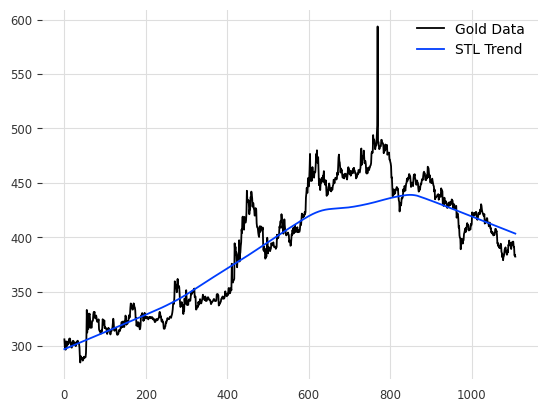

In [ ]:
plt.plot(y_filled, label='Gold Data')
plt.plot(res.trend, label='STL Trend')
plt.legend()

Then, let's detrend the series:

In [ ]:
detrended = y_filled - res.trend

We should look for outlies in the remainder of the series (that is, after both trend and seasonality are removed). There does not seem to be any apparent seasonality. But, how can we be sure of it?

We can compute the strength of the seasonality and, should it be greater than 0.6 we remove the seasonality as well.

0.008496044074811748

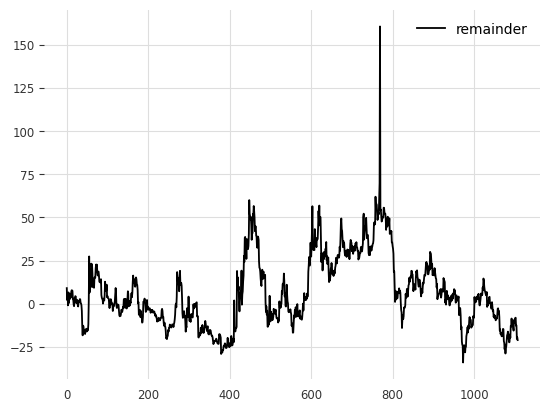

In [ ]:
Fseason = max(0, 1 - np.var(detrended-res.seasonal)/np.var(detrended))

if Fseason >= .6:
    remainder = detrended - res.seasonal
else:
    remainder = detrended

plt.plot(remainder, label='remainder')
plt.legend()
Fseason

This is the series we'll use to look for outliers using Tukey's fences.

In [ ]:
# use Tukey / IQR = Q3 - Q1 / Q1 - 3*IQR and Q3 + 3*IQR
# use interpolation to replace values
Q1, Q3 = np.quantile(remainder, [.25, .75])
IQR = Q3 - Q1
fence = [Q1 - 3*IQR, Q3 + 3*IQR]
fence

[-85.94824021636283, 96.62283005955268]

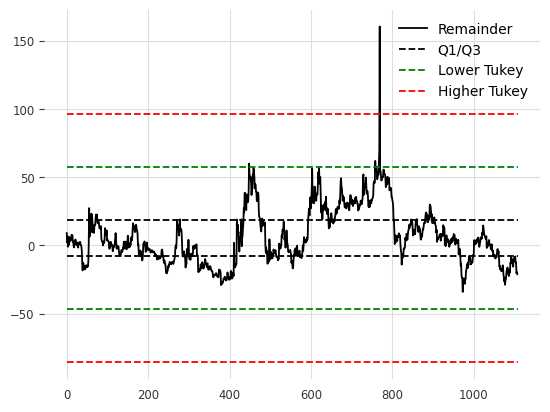

In [ ]:
plt.plot(remainder, label='Remainder')
plt.plot([0, len(remainder)], [Q1, Q1], c='k', linestyle='--', label='Q1/Q3')
plt.plot([0, len(remainder)], [Q3, Q3], c='k', linestyle='--')
plt.plot([0, len(remainder)], [Q1-1.5*IQR, Q1-1.5*IQR], c='g', linestyle='--', label='Lower Tukey')
plt.plot([0, len(remainder)], [Q3+1.5*IQR, Q3+1.5*IQR], c='g', linestyle='--')
plt.plot([0, len(remainder)], [fence[0], fence[0]], c='r', linestyle='--', label='Higher Tukey')
plt.plot([0, len(remainder)], [fence[1], fence[1]], c='r', linestyle='--')
plt.legend()

Clearly, there's one point way off the higher red fences. Let's check this point out in the original series:

In [ ]:
outliers = (remainder > fence[1]) | (remainder < fence[0])
y[np.argwhere(outliers)]

array([[593.7]])

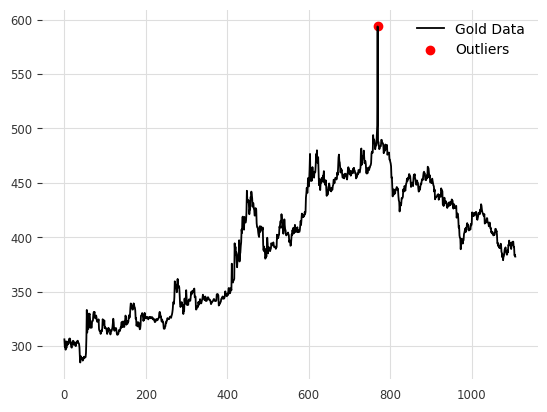

In [ ]:
plt.plot(y_filled, label='Gold Data')
plt.scatter(np.argwhere(outliers), y[np.argwhere(outliers)], c='r', label='Outliers')
plt.legend()

We found our outlier! What's next? We need to handle it somehow. One alternative is to remove the outlier and treat it as a missing value:

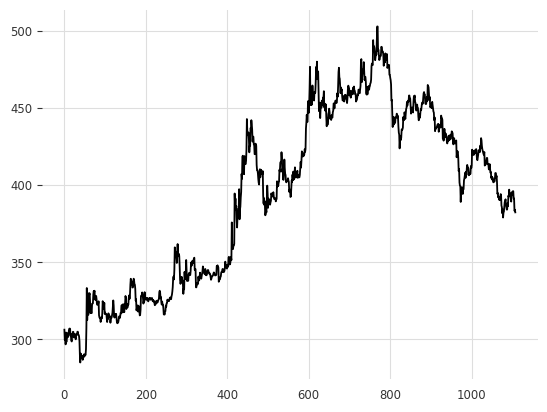

In [ ]:
y_filled[np.argwhere(outliers)] = np.nan
transformer = Imputer(method="nearest")
transformer.fit(y_filled)
y_filled = transformer.transform(y_filled).squeeze()

plt.plot(y_filled, label='Gold Data')